# Second Project Work Week Assignment
### Authors: Dan Davieau, Paul Panek, Olga Tanyuk, Nathan Wall

### Initial Data Prep

For the purpose of this assignment we view the data prep as conditional to the specific classification task. However, there are several minor data cleaning tasks that are applicable to either task and are performed in the code below

In [48]:
import pandas as pd
import numpy as np

df = pd.read_csv('DefaultCreditcardClients.csv')
df.rename(columns={'default payment next month':'default'}, inplace=True)

#set index to the "ID" value and remove the ID column
df.index = df.ID
del df['ID']

#Create Lists for Analysis
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
ordinal_features = ['EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6','default']

#Convert datatypes
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#Log transform continuous variables; as they each have a mostly 
##exponential distribution
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)
df["log_PAY_AMT2"]=np.log(df.PAY_AMT2+1)
df["log_PAY_AMT3"]=np.log(df.PAY_AMT3+1)
df["log_PAY_AMT4"]=np.log(df.PAY_AMT4+1)
df["log_PAY_AMT5"]=np.log(df.PAY_AMT5+1)
df["log_PAY_AMT6"]=np.log(df.PAY_AMT6+1)
df["log_BILL_AMT1"]=np.log(df.BILL_AMT1.abs()+1)
df["log_BILL_AMT2"]=np.log(df.BILL_AMT2.abs()+1)
df["log_BILL_AMT3"]=np.log(df.BILL_AMT3.abs()+1)
df["log_BILL_AMT4"]=np.log(df.BILL_AMT4.abs()+1)
df["log_BILL_AMT5"]=np.log(df.BILL_AMT5.abs()+1)
df["log_BILL_AMT6"]=np.log(df.BILL_AMT6.abs()+1)

df['COLLEGE'] = np.where(df['EDUCATION']==2, 1, 0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 38 columns):
LIMIT_BAL        30000 non-null float64
SEX              30000 non-null int64
EDUCATION        30000 non-null int64
MARRIAGE         30000 non-null int64
AGE              30000 non-null int64
PAY_0            30000 non-null int64
PAY_2            30000 non-null int64
PAY_3            30000 non-null int64
PAY_4            30000 non-null int64
PAY_5            30000 non-null int64
PAY_6            30000 non-null int64
BILL_AMT1        30000 non-null float64
BILL_AMT2        30000 non-null float64
BILL_AMT3        30000 non-null float64
BILL_AMT4        30000 non-null float64
BILL_AMT5        30000 non-null float64
BILL_AMT6        30000 non-null float64
PAY_AMT1         30000 non-null float64
PAY_AMT2         30000 non-null float64
PAY_AMT3         30000 non-null float64
PAY_AMT4         30000 non-null float64
PAY_AMT5         30000 non-null float64
PAY_AMT6         30000 non-null

# Predicting Customer "Default"
The first portion of the report we will explore various models to try and classify customer's likelihood of default.

### Modeling & Evaluation Considerations

Part 1)
For this particular classification model we will assessing our models based on their F1 scores.

A client may use this model to determine which customer-facing strategies to deploy for a given customer. If a customer is expected to default, there should be a more intesive collection strategy, and management of credit lines should be more conservative. While such strategies are designed to limit losses from defaults, they may also lead to sub-optimal customer experiences for those who do not default. Customers who are treated as likely to default are expected to attrit if they do not default.

Precision is therefore important. Low precision would lead to higher customer attrition. Recall is also important. Low Recall represents missed opportunity to apply loss-mitigation strategies to customer who need them, and will result in high default costs.

Since balancing these two factors is important, we will choose F1 as the evaluation metric for this suite of models.

Part 2)
In order to effectively evaluate our model performance we will splitting our data into training & test sets using an initial 80/20 split. Additionally, due to the class imbalance between default customers and non-default customers we will be oversampling default customers in our training data. If left unbalanced our model will bias towards assuming most customers will not default. This is a costly bias as described above. In order to overcome that limitation we will provide the classifiers more examples of default by sampling from replacement from our positive cases.

### Data Preperation - Default Classification Specific
Below we perform several steps that explain some of the data preparation tasks that are specific to the goal of classifying customers default on credit card payments.

First we remove the variables that we identified as not important from Lab1 & Mini-Lab1. We also one hot encode our categorical features for use in our models. Below you will find the fields that are considered in our model.

Field Definitions:
- The items in the final data set are shown below.
- Monetary amounts are in New Taiwanese dollars
- SEX
    * 1 = Male
    * 2 = Female
- AGE = Credit Card holder age in years
- default: Whether or not the customer defaulted (Target for predicting default)
- Payment history (2005)
- PAY_0 = September
- PAY_2 = August
- PAY_3 = July
- PAY_4 = June
- PAY_5 = May
- PAY_6 = April
-1 = payment received on time
    - 1 = payment received one month late
    - 2 = payment received two months late
    - 9 = payment received nine months late or more
- log_LIMIT_BAL: Natural log of the Credit Limit (max amount of credit allowed)
- log_PAY_AMT: Natural log of the amount paid by month + $1
- log_PAY_AMT1 = September
- log_PAY_AMT2 = August
- log_PAY_AMT3 = July
- log_PAY_AMT4 = June
- log_PAY_AMT5 = May
- log_PAY_AMT6 = April
- EDUCATION (One-Hot Encoded when Predicting Default. Used in the form below when used as target.)
- EDUCATION_1 = Graduate School
- EDUCATION_2 = University
- EDUCATION_3 = High School
- EDUCATION_4 = Other
- EDUCATION (This variable appears only as the target only when predicting Education. Not one-hot encoded.)
- 1 = Graduate School
- 2 = University
- 3 = High School
- 4 = Other
- MARRIAGE (One-Hot Encoded)
- MARRIAGE_1 = Married
- MARRIAGE_2 = Single
- MARRIAGE_3 = Other

In [49]:
#Create a separate dataset with only useful variables as identified in Lab1 and Mini-lab1.
default = df[['SEX','EDUCATION','MARRIAGE','AGE', 'default'
            ,'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6', "log_LIMIT_BAL"
            ,"log_PAY_AMT1","log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5"
            ,"log_PAY_AMT6"]]

# One-hot encoding of "EDUCATION" and "MARRIAGE".
tmp_df_1 = pd.get_dummies(default.EDUCATION,prefix='EDUCATION')
tmp_df_2 = pd.get_dummies(default.MARRIAGE,prefix='MARRIAGE')
default = pd.concat((default,tmp_df_1,tmp_df_2),axis=1)
#Drop variables for which we used one-hot encoding
del default['EDUCATION']
del default['MARRIAGE']
default.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 23 columns):
SEX              30000 non-null int64
AGE              30000 non-null int64
default          30000 non-null int64
PAY_0            30000 non-null int64
PAY_2            30000 non-null int64
PAY_3            30000 non-null int64
PAY_4            30000 non-null int64
PAY_5            30000 non-null int64
PAY_6            30000 non-null int64
log_LIMIT_BAL    30000 non-null float64
log_PAY_AMT1     30000 non-null float64
log_PAY_AMT2     30000 non-null float64
log_PAY_AMT3     30000 non-null float64
log_PAY_AMT4     30000 non-null float64
log_PAY_AMT5     30000 non-null float64
log_PAY_AMT6     30000 non-null float64
EDUCATION_1      30000 non-null uint8
EDUCATION_2      30000 non-null uint8
EDUCATION_3      30000 non-null uint8
EDUCATION_4      30000 non-null uint8
MARRIAGE_1       30000 non-null uint8
MARRIAGE_2       30000 non-null uint8
MARRIAGE_3       30000 non-null uint8
dty

Once the dataset is cleaned and the variables are prepared, we begin the process of building our training and test datasets for use in building our models. Below is we split our data into test and traing sets and fit our scaler using the training data before we oversample.

In [50]:
from sklearn.preprocessing import StandardScaler

split = np.random.rand(len(default)) < 0.8

default_train = default[split]
default_test = default[~split]

# fit training for scaling after upsampling
X_train = default_train.drop(columns=['default']).values     
scl_obj = StandardScaler()
scl_obj.fit(X_train)

print("Dimensions of training data " , default_train.shape)
print("Dimensions of test are " , default_test.shape)

default_train.info()

Dimensions of training data  (23924, 23)
Dimensions of test are  (6076, 23)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23924 entries, 1 to 30000
Data columns (total 23 columns):
SEX              23924 non-null int64
AGE              23924 non-null int64
default          23924 non-null int64
PAY_0            23924 non-null int64
PAY_2            23924 non-null int64
PAY_3            23924 non-null int64
PAY_4            23924 non-null int64
PAY_5            23924 non-null int64
PAY_6            23924 non-null int64
log_LIMIT_BAL    23924 non-null float64
log_PAY_AMT1     23924 non-null float64
log_PAY_AMT2     23924 non-null float64
log_PAY_AMT3     23924 non-null float64
log_PAY_AMT4     23924 non-null float64
log_PAY_AMT5     23924 non-null float64
log_PAY_AMT6     23924 non-null float64
EDUCATION_1      23924 non-null uint8
EDUCATION_2      23924 non-null uint8
EDUCATION_3      23924 non-null uint8
EDUCATION_4      23924 non-null uint8
MARRIAGE_1       23924 non-null uint8
MAR

Once we have the data split and have performed the neccesary operations on the training data we can then begin building our oversampled training data then apply our scaler to the training and test data sets to begin exploring different estimators.

Dimensions of final training features are  (37193, 22)


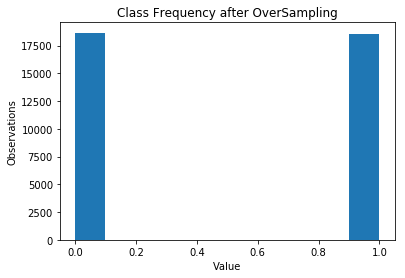

In [51]:
target_count = default.default.value_counts()
# Class count
default_class_0, default_class_1 = default_train.default.value_counts()

# Divide by class
default_class_0 = default_train[default_train['default'] == 0]
default_class_1 = default_train[default_train['default'] == 1]

default_class_1_over = default_class_1.sample(frac=target_count[0]/target_count[1], replace=True)
default_OverSampled = pd.concat([default_class_0, default_class_1_over], axis=0)

#Isolate the "default" variable into y and keep everythign else in X to use for predictions:
if 'default' in default_OverSampled:
    y_train = default_OverSampled['default'].values
    del default_OverSampled['default'] 
    X_train = default_OverSampled.values
    
if 'default' in default_test:
    y_test = default_test['default'].values
    del default_test['default'] 
    X_test = default_test.values

# use the previously fit scalines to transform the data after the over sampling
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)


print("Dimensions of final training features are " , X_train_scaled.shape)
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(y_train )
plt.xlabel('Value')
plt.ylabel('Observations')
plt.title('Class Frequency after OverSampling')
plt.show()

From above we can see that we now have 37k observations in our training set and the labels are balanced. We can now proceed with our reviewing various estimators and how they perform when classifying customer defaults.

### Comparing Different Classifier Models (Part 3)

For this particular problem we will compare three different models:

1. Support Vector Machine
2. K Nearest Neighbor 
3. Random Forest

To ensure we are chosing the right parameters of each model we will be using sklearns GridSearchCV with a 3 fold cross validation to identify the best estimators based on the F1 scores. This provides us a dynamic means of testing out many different model parameters. The constraint is that the Smallest Categorical Variable (Marriage_3) has less than 400 observations. We did not want to go below 3 for the number of folds for this search, to not go lower than approximately 100 observations for that variable.

We first train each model and look at some metrics for preliminary evaluation, then evaluate each model more thoroughly once all the models have been developed.

In [59]:
# function for plotting class accuracies
from matplotlib import pyplot as plt

def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Not Default and Default')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.show()

### SVM Classification

In [5]:
from sklearn.svm import SVC

svcEstimator = SVC()
cv = 3

#compare various values of C, kernels (rbf vs linear vs poly),decision_function_shape (ovo vs ovr) 
parameters = { 'C': [0.01, 0.1, 1]
              ,'kernel': ['rbf','linear','poly']
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
svcGridSearch = GridSearchCV(estimator=svcEstimator
                    , n_jobs=8 # jobs to run in parallel
                    , verbose=1 # low verbosity
                    , param_grid=parameters
                    , cv=cv # KFolds = 2
                    , scoring='f1')

#Perform hyperparameter search to find the best combination of parameters for our data
svcGridSearch.fit(X_train_scaled, y_train)
#Display the best estimator parameters
print("The best estimator based on F1 is ", svcGridSearch.best_estimator_)
svm_clf = svcGridSearch.best_estimator_ 

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:  9.6min finished


The best estimator based on F1 is  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [55]:
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print(svm_clf)

clf = svm_clf

clf.fit(X_train_scaled,y_train)
yhat_svm = clf.predict(X_test_scaled)
    
total_accuracy = mt.accuracy_score(y_test, yhat_svm)
print ('Accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat_svm)
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat_svm))
print('Precision:', precision_score(y_test, yhat_svm))
print('Recall:', recall_score(y_test, yhat_svm)) 

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy 0.7710664911125741
Confusion matrix:
[[3863  841]
 [ 550  822]]
f1_score: 0.54168039538715
Precision: 0.49428743235117256
Recall: 0.5991253644314869


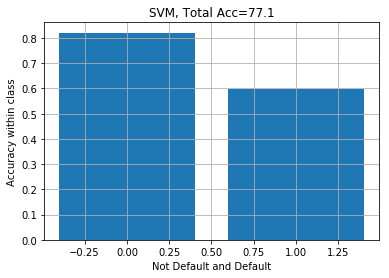

In [61]:
plot_class_acc(y_test,yhat_svm,title="SVM")

### K-Nearest Neighbor

In [7]:
from sklearn.neighbors import KNeighborsClassifier
svcEstimator = KNeighborsClassifier()
cv = 3

#compare various values of C, kernels (rbf vs linear vs poly),decision_function_shape (ovo vs ovr) 
parameters = {'n_neighbors': [3,5,7,11]}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
svcGridSearch = GridSearchCV(estimator=svcEstimator
                    , n_jobs=8 # jobs to run in parallel
                    , verbose=1 # low verbosity
                    , param_grid=parameters
                    , cv=cv # KFolds = 3
                    , scoring='accuracy')

svcGridSearch.fit(X_train_scaled, y_train)
print("The best estimator based on F1 is ", svcGridSearch.best_estimator_)
knn_clf = svcGridSearch.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=8)]: Done  10 out of  12 | elapsed:  3.2min remaining:   38.9s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:  3.4min finished


The best estimator based on F1 is  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


In [56]:
print(knn_clf)

clf = knn_clf

clf.fit(X_train_scaled,y_train)
yhat_knn = clf.predict(X_test_scaled)
    
total_accuracy = mt.accuracy_score(y_test, yhat_knn)
print ('Accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat_knn)
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat_knn))
print('Precision:', precision_score(y_test, yhat_knn))
print('Recall:', recall_score(y_test, yhat_knn)) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
Accuracy 0.695852534562212
Confusion matrix:
[[3476 1228]
 [ 620  752]]
f1_score: 0.4486873508353222
Precision: 0.3797979797979798
Recall: 0.5481049562682215


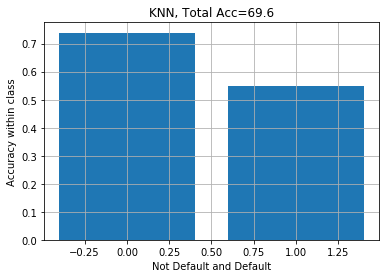

In [62]:
plot_class_acc(y_test,yhat_knn,title="KNN")

### Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
svcEstimator = RandomForestClassifier()
cv = 3

#compare various values of C, kernels (rbf vs linear vs poly),decision_function_shape (ovo vs ovr) 
parameters = {'n_estimators': [100,250,500]
             , 'max_depth': [5,25,50,100]}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
svcGridSearch = GridSearchCV(estimator=svcEstimator
                    , n_jobs=8 # jobs to run in parallel
                    , verbose=1 # low verbosity
                    , param_grid=parameters
                    , cv=cv # KFolds = 3
                    , scoring='accuracy')

svcGridSearch.fit(X_train_scaled, y_train)
print("The best estimator based on F1 is ", svcGridSearch.best_estimator_)
rf_clf = svcGridSearch.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:  2.1min finished


The best estimator based on F1 is  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [57]:
clf = rf_clf

clf.fit(X_train_scaled,y_train)
yhat_rf  = clf.predict(X_test_scaled)
    
total_accuracy = mt.accuracy_score(y_test, yhat_rf)
print ('Accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat_rf )
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat_rf ))
print('Precision:', precision_score(y_test, yhat_rf ))
print('Recall:', recall_score(y_test, yhat_rf )) 

Accuracy 0.8100724160631995
Confusion matrix:
[[4334  370]
 [ 784  588]]
f1_score: 0.5047210300429184
Precision: 0.6137787056367432
Recall: 0.42857142857142855


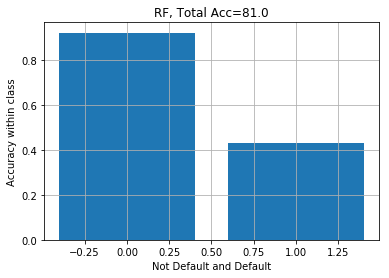

In [63]:
plot_class_acc(y_test,yhat_rf,title="RF")

### Classifier Evaluation
In the following section we evaluate the different classifiers and determine the model that we would like to use going forward.

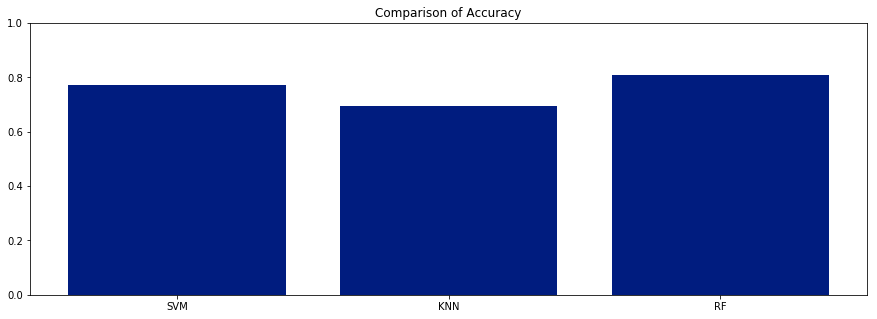

SVM overall accuracy is  0.7710664911125741
KNN overall accuracy is  0.695852534562212
RF overall accuracy is  0.8100724160631995


In [71]:
accur_svm = mt.accuracy_score(y_test, yhat_svm)
accur_knn = mt.accuracy_score(y_test, yhat_knn)
accur_rf = mt.accuracy_score(y_test, yhat_rf)
x = np.arange(3)

import seaborn as sns
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.bar(x,[accur_svm, accur_knn, accur_rf])
plt.xticks(x, ('SVM', 'KNN', 'RF'))
plt.ylim([0,1])
plt.title('Comparison of Accuracy')
plt.show()

print("SVM overall accuracy is ", accur_svm)
print("KNN overall accuracy is ", accur_knn)
print("RF overall accuracy is ", accur_rf)


From above we are able to see that the model that acheived the highest accuracy is the Random Forest model. However, the measurement we are focusing on is the F1 so let us take a look at how those compare.

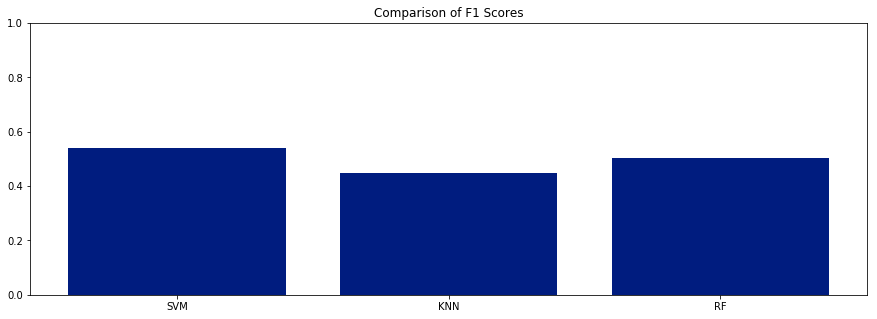

SVM F1 is  0.54168039538715
KNN F1 is  0.4486873508353222
RF F1 is  0.5047210300429184


In [72]:
f1_svm = f1_score(y_test, yhat_svm)
f1_knn = f1_score(y_test, yhat_knn)
f1_rf = f1_score(y_test, yhat_rf)
x = np.arange(3)

import seaborn as sns
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.bar(x,[f1_svm, f1_knn, f1_rf])
plt.xticks(x, ('SVM', 'KNN', 'RF'))
plt.ylim([0,1])
plt.title('Comparison of F1 Scores')
plt.show()

print("SVM F1 is ", f1_svm)
print("KNN F1 is ", f1_knn)
print("RF F1 is ", f1_rf)


Interestingly while the Random Forest provided the highes overall accuracy the Support Vector machine classifier has the highest F1 value. This makes sense when you take into the account the class accuracies we saw above. The random forest model did a very good job at predicting customers who did not end up defaulting, but did not do well when predicting customers that would default. Meanwhile the SVM model was able to identify customers who defaulted at a 60% rate.

The Table below shows various statistics to evaluate the effectiveness of our models for both this classification and the next.

From an error rate perspective, the best model to predict defaults is Random Forest. The differences shown in the table below,  are significant at the 95% confidence level. These intervals were calculated by hand in excel.

The primary statistic we will evaluate our model on, as stated earlier, is F1.  This is because it focuses on the % of positive cases modeled correctly and the % of positive predictions which are correct.  This is consistent with the assumed business/client objectives.

In terms of F1, the best model to predict Default is the Support Vector Machine.

In general with some exceptions, in terms of F1, Precision and Recall which are the metrics we are interested in, SVC and Random Forest models are fairly close to each other. In general, KNN lags the other models with the exception of Recall in predicting default.  In that instance, the Random Forest model performed poorly.

While in ROC Curves and Precision/Recall curves would normally be interesting in evaluating and comparing models, they are not particularly relevant here because not all models are "score-Based".


![](Default95CI.PNG)

### Feature Importance

Based on the analysis above we determined that the Support Vector classifier is our best performing model based on the F1 statistic. In order to understand a little more about that model lets take a look at some of the important features and hypothesis some potential explanations of the what the model is learning.

(23199, 22)
(23199,)
[11281 11918]


C:\Users\bsnxw01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


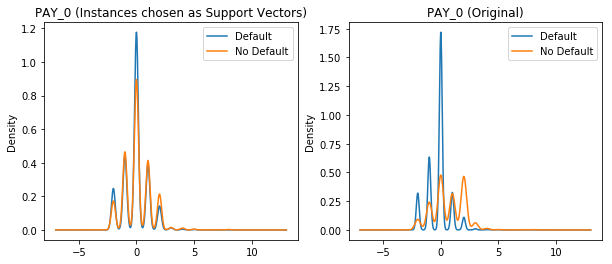

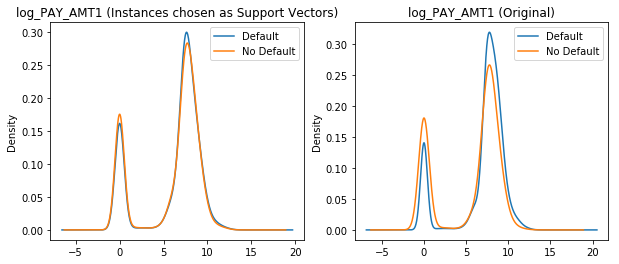

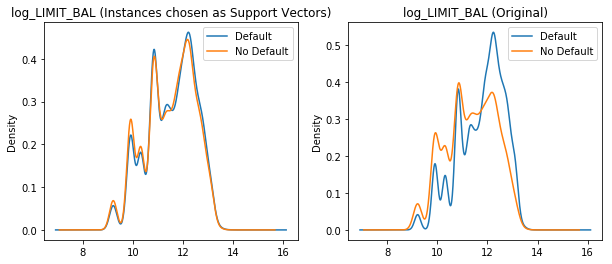

In [25]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )


# get the support vectors from the trained model
df_support = default_OverSampled.iloc[svm_clf.support_,:]

df_support['default'] = y_train[svm_clf.support_] 
default_OverSampled['default'] = y_train # also add it back in for the original data

# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['default'])
df_grouped = default.groupby(['default'])

# plot KDE of Different variables
vars_to_plot = ['PAY_0','log_PAY_AMT1','log_LIMIT_BAL']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Default','No Default'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Default','No Default'])
    plt.title(v+' (Original)')


Based on the charts from above, we can see that the separation in three distributions is not as great as the separation for the original data. 

Given, that the chosen support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data. 

Once way to interpret this is that as we move closer towards the class boundaries the values of the three features share begin to share a more similar statistical profile between the two classes. Meaning the seperation of the two classes may be largely dependent on the values in these three features. 

Given the seperation we see in the two classes and our past experiences with logistic regression these three features exhibit some sort of pattern that this SVM classifier is picking up on.

1. PAY_0 is the variable that indicates the payment status of the last payment, with postive integers indicating how many months late the payment was. This seems intuitive that it this would be telling us the more delinquent the payment, the more likely the account is to default.

2. log_PAY_AMT_1 the log of the most recent payment amount. It seems likely that customers that are able to higher amounts for their last statement they will likely be able to make at least the minimum payment for the month we are trying to predict.

3. log_LIMIT_BAL this feature would likely lead us to believe that the higher the balance limit the bank has given a customer the less likely they would be to default. This makes sense if you think about how the bank would conduct business. Reliable customers can be affored higher credit limits as they are a lower risk investment.


# Predicting Education Level from Credit History
The goal of these models is to try and classify a customer as having post graduate education vs not having post graduate education. 

### Modeling & Evaluation Considerations

Part 1)

One use for this suite of models is to apply marketing strategies for other products to these demographic groups if the customer does not provide the information.

The evaluation metric should again consider a balance between Recall and Precision. Low Recall again represents a missed opportunity to apply a more targeted strategy, and low Precision would result in the wrong strategy applied to a given prospect.

Applying the wrong strategy can be expected to decrease the credibility of the business in the customer's view, and may make the customer less likely to respond to other offers.

Since F1 considers both, we will choose it as the evaluation metric for this as well.

Part 2)

Our cross validation technique is the same as before. We split the data into training and test sets using an 80/20 split. Using the training data to train our models and evaluating on the remaining 20. We do not have the same class imbalance problem as the other classifier so we do not have to address this 

### Data Preperation - Education Classification Specific
Below we perform several steps that explain some of the data preparation tasks that are specific to the goal of classifying education.

Field Definitions:
- The items in the final data set are shown below.
- Monetary amounts are in New Taiwanese dollars
- SEX
    * 1 = Male
    * 2 = Female
- AGE = Credit Card holder age in years
- default: Whether or not the customer defaulted (Target for predicting default)
- Payment history (2005)
- PAY_0 = September
- PAY_2 = August
- PAY_3 = July
- PAY_4 = June
- PAY_5 = May
- PAY_6 = April
-1 = payment received on time
    - 1 = payment received one month late
    - 2 = payment received two months late
    - 9 = payment received nine months late or more
- log_LIMIT_BAL: Natural log of the Credit Limit (max amount of credit allowed)
- log_PAY_AMT: Natural log of the amount paid by month + $1
- log_PAY_AMT1 = September
- log_PAY_AMT2 = August
- log_PAY_AMT3 = July
- log_PAY_AMT4 = June
- log_PAY_AMT5 = May
- log_PAY_AMT6 = April
- log_BILL_AMT1 = September
- log_BILL_AMT2 = August
- log_BILL_AMT3 = July
- log_BILL_AMT4 = June
- log_BILL_AMT5 = May
- log_BILL_AMT6 = April
- COLLEGE - Binary response variable where 1 indicates Post Grad education & 0 indicates High School, Undergrad, or Other
- MARRIAGE (One-Hot Encoded)
- MARRIAGE_1 = Married
- MARRIAGE_2 = Single
- MARRIAGE_3 = Other

In [73]:
#Create a separate dataset with only useful variables as identified in Lab1 and Mini-lab1.
educ = df[['SEX','COLLEGE','MARRIAGE','AGE', 'default'
            ,'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6', "log_LIMIT_BAL"
            ,"log_PAY_AMT1","log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5"
            ,"log_PAY_AMT6", "log_BILL_AMT1","log_BILL_AMT2","log_BILL_AMT3",
             "log_BILL_AMT4","log_BILL_AMT5","log_BILL_AMT6"]]
educ.info()

# # # perform one-hot encoding of the categorical data "EDUCATION" and "MARRIAGE".
tmp_df_2 = pd.get_dummies(df.MARRIAGE,prefix='MARRIAGE')
educ = pd.concat((educ,tmp_df_2),axis=1)
del educ['MARRIAGE']

from sklearn.model_selection import ShuffleSplit

y = educ['COLLEGE'].values # get the labels we want
del educ['COLLEGE'] # get rid of the class label
X = educ.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 5
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
SEX              30000 non-null int64
COLLEGE          30000 non-null int32
MARRIAGE         30000 non-null int64
AGE              30000 non-null int64
default          30000 non-null int64
PAY_0            30000 non-null int64
PAY_2            30000 non-null int64
PAY_3            30000 non-null int64
PAY_4            30000 non-null int64
PAY_5            30000 non-null int64
PAY_6            30000 non-null int64
log_LIMIT_BAL    30000 non-null float64
log_PAY_AMT1     30000 non-null float64
log_PAY_AMT2     30000 non-null float64
log_PAY_AMT3     30000 non-null float64
log_PAY_AMT4     30000 non-null float64
log_PAY_AMT5     30000 non-null float64
log_PAY_AMT6     30000 non-null float64
log_BILL_AMT1    30000 non-null float64
log_BILL_AMT2    30000 non-null float64
log_BILL_AMT3    30000 non-null float64
log_BILL_AMT4    30000 non-null float64
log_BILL_AMT5    30000 non-null f

In [74]:
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()

for train_indices, test_indices in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test)

print("Dimensions of training features are " , X_train.shape)
print("Dimensions of training target are " , y_train.shape)
print("Dimensions of testing features are " , X_test.shape)
print("Dimensions of testing target are " , y_test.shape)

Dimensions of training features are  (24000, 25)
Dimensions of training target are  (24000,)
Dimensions of testing features are  (6000, 25)
Dimensions of testing target are  (6000,)


### Comparing Different Classifier Models

For this particular problem we will compare three different models:

1. Support Vector Machine
2. K Nearest Neighbor 
3. Random Forest

To ensure we are chosing the right parameters of each model we will be using sklearns GridSearchCV with a 3 fold cross validation to identify the best estimators based on the accuracy. 

### Support Vector Machines

In [30]:
from sklearn.svm import SVC

svcEstimator = SVC()
cv = 3

#compare various values of C, kernels (rbf vs linear vs poly),decision_function_shape (ovo vs ovr) 
parameters = { 'C': [0.01, 0.1, 1]
              ,'kernel': ['rbf','linear','poly']
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
svcGridSearch = GridSearchCV(estimator=svcEstimator
                    , n_jobs=8 # jobs to run in parallel
                    , verbose=1 # low verbosity
                    , param_grid=parameters
                    , cv=cv # KFolds = 2
                    , scoring='f1')

#Perform hyperparameter search to find the best combination of parameters for our data
svcGridSearch.fit(X_train_scaled, y_train)
#Display the best estimator parameters
print("The best estimator based on F1 is ", svcGridSearch.best_estimator_)
svm_clf2 = svcGridSearch.best_estimator_ 

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:  7.4min finished


The best estimator based on F1 is  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [78]:
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print(svm_clf2)

clf = svm_clf2

clf.fit(X_train_scaled,y_train)
yhat_svm2 = clf.predict(X_test_scaled)
    
total_accuracy = mt.accuracy_score(y_test, yhat_svm2)
print ('Accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat_svm2)
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat_svm2))
print('Precision:', precision_score(y_test, yhat_svm2))
print('Recall:', recall_score(y_test, yhat_svm2))

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy 0.5993333333333334
Confusion matrix:
[[2088 1007]
 [1397 1508]]
f1_score: 0.5564575645756458
Precision: 0.5996023856858846
Recall: 0.519104991394148


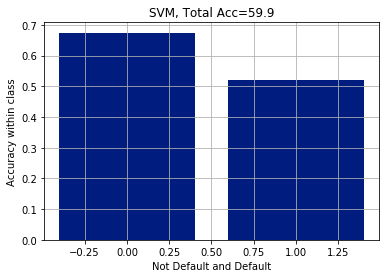

In [79]:
plot_class_acc(y_test,yhat_svm2,title="SVM")

### K-Nearest Neighbor

In [32]:
from sklearn.neighbors import KNeighborsClassifier
svcEstimator = KNeighborsClassifier()
cv = 3

#compare various values of C, kernels (rbf vs linear vs poly),decision_function_shape (ovo vs ovr) 
parameters = {'n_neighbors': [3,5,7,11]}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
svcGridSearch = GridSearchCV(estimator=svcEstimator
                    , n_jobs=8 # jobs to run in parallel
                    , verbose=1 # low verbosity
                    , param_grid=parameters
                    , cv=cv # KFolds = 3
                    , scoring='accuracy')

svcGridSearch.fit(X_train_scaled, y_train)
print("The best estimator based on F1 is ", svcGridSearch.best_estimator_)
knn_clf2 = svcGridSearch.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=8)]: Done  10 out of  12 | elapsed:  1.6min remaining:   18.6s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:  1.6min finished


The best estimator based on F1 is  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')


In [80]:
print(knn_clf2)

clf = knn_clf2

clf.fit(X_train_scaled,y_train)
yhat_knn2 = clf.predict(X_test_scaled)
    
total_accuracy = mt.accuracy_score(y_test, yhat_knn2)
print ('Accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat_knn2)
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat_knn2))
print('Precision:', precision_score(y_test, yhat_knn2))
print('Recall:', recall_score(y_test, yhat_knn2)) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')
Accuracy 0.5621666666666667
Confusion matrix:
[[1930 1165]
 [1462 1443]]
f1_score: 0.5234899328859061
Precision: 0.55329754601227
Recall: 0.49672977624784853


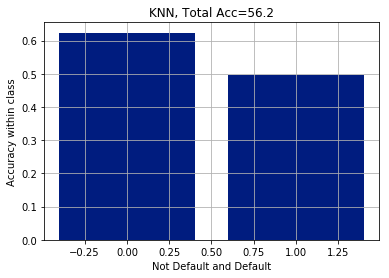

In [81]:
plot_class_acc(y_test,yhat_knn2,title="KNN")

### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
svcEstimator = RandomForestClassifier()
cv = 3

#compare various values of C, kernels (rbf vs linear vs poly),decision_function_shape (ovo vs ovr) 
parameters = {'n_estimators': [100,250,500]
             , 'max_depth': [5,25,50,100]}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
svcGridSearch = GridSearchCV(estimator=svcEstimator
                    , n_jobs=8 # jobs to run in parallel
                    , verbose=1 # low verbosity
                    , param_grid=parameters
                    , cv=cv # KFolds = 3
                    , scoring='accuracy')

svcGridSearch.fit(X_train_scaled, y_train)
print("The best estimator based on F1 is ", svcGridSearch.best_estimator_)
rf_clf2 = svcGridSearch.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:  2.0min finished


The best estimator based on F1 is  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [82]:
print(rf_clf2)

clf = rf_clf2

clf.fit(X_train_scaled,y_train)
yhat_rf2 = clf.predict(X_test_scaled)
    
total_accuracy = mt.accuracy_score(y_test, yhat_rf2)
print ('Accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat_rf2)
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat_rf2))
print('Precision:', precision_score(y_test, yhat_rf2))
print('Recall:', recall_score(y_test, yhat_rf2)) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy 0.5953333333333334
Confusion matrix:
[[2018 1077]
 [1351 1554]]
f1_score: 0.5614161849710984
Precision: 0.5906499429874572
Recall: 0.5349397590361445


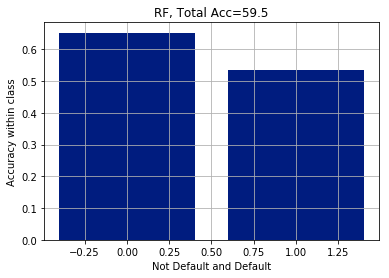

In [83]:
plot_class_acc(y_test,yhat_rf2,title="RF")

### Model Evaluations

Below we will evaluate the different models and select one that we believe is the best performant for the particular goal of the classifier.

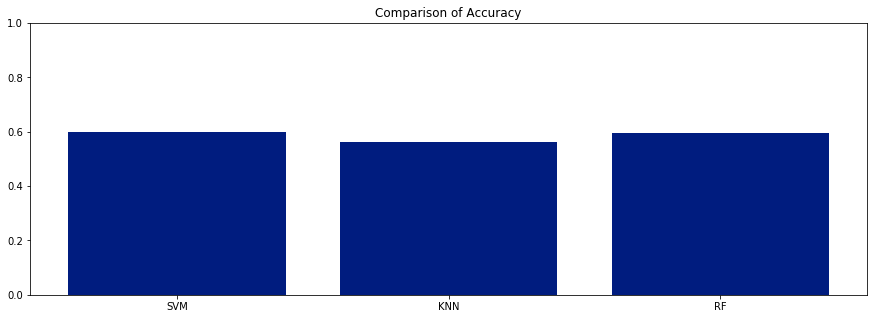

SVM overall accuracy is  0.5993333333333334
KNN overall accuracy is  0.5621666666666667
RF overall accuracy is  0.5953333333333334


In [84]:
accur_svm2 = mt.accuracy_score(y_test, yhat_svm2)
accur_knn2 = mt.accuracy_score(y_test, yhat_knn2)
accur_rf2 = mt.accuracy_score(y_test, yhat_rf2)
x = np.arange(3)

import seaborn as sns
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.bar(x,[accur_svm2, accur_knn2, accur_rf2])
plt.xticks(x, ('SVM', 'KNN', 'RF'))
plt.ylim([0,1])
plt.title('Comparison of Accuracy')
plt.show()

print("SVM overall accuracy is ", accur_svm2)
print("KNN overall accuracy is ", accur_knn2)
print("RF overall accuracy is ", accur_rf2)


A comparison of accuracy between the different models shows that none of the models perform relatively well. Also we do not see that much a difference between the models. Next we review the F1 to better compare.

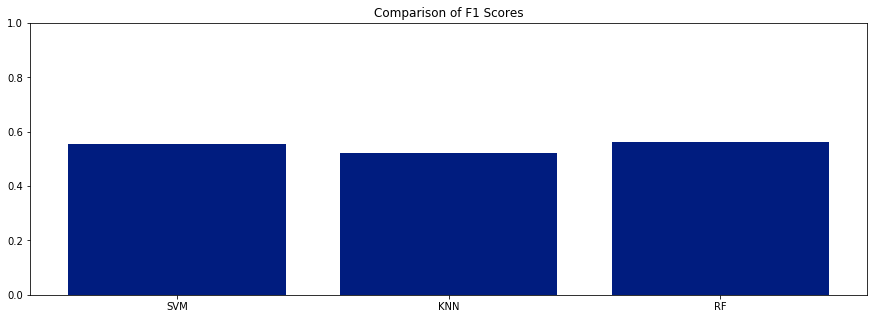

SVM F1 is  0.5564575645756458
KNN F1 is  0.5234899328859061
RF F1 is  0.5614161849710984


In [86]:
f1_svm2 = f1_score(y_test, yhat_svm2)
f1_knn2 = f1_score(y_test, yhat_knn2)
f1_rf2 = f1_score(y_test, yhat_rf2)
x = np.arange(3)

import seaborn as sns
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.bar(x,[f1_svm2, f1_knn2, f1_rf2])
plt.xticks(x, ('SVM', 'KNN', 'RF'))
plt.ylim([0,1])
plt.title('Comparison of F1 Scores')
plt.show()

print("SVM F1 is ", f1_svm2)
print("KNN F1 is ", f1_knn2)
print("RF F1 is ", f1_rf2)


Similarly to the the accuracy there isn't a noticeable difference between the various F1 statitistics even though Random Forest does seem to have a slight edge. However, it is important to consider the purpose of the this model. The intention was to provide the marketing team interesting insights into some of the features important to classifying education. That makes model interpretability an important factor in selecting our model choice. That makes Random Forest the ideal choice since there isn't any real differences between the models. 

Below we take a look at the 95% CI between the Accuracies. Again these were calculated by hand using excel.

![](Education95CI.PNG)

### Feature Importance

As we describe above based on the F1 statistic we have determined that the Random Forest model was the most ideal model for our analysis. One benefit of that is how relatively easy it is to determine feature importance the trained model. This is acheivable by identifying features or splits that are commmon across many of the trees in the forest.

Luckily for us the sklearn package produces the feature importance in the random forest object, so we can easily plot them and make some hypthesis.


Top 3 Feature Importances for Classifying Education


,importance
log_LIMIT_BAL,0.149489
PAY_2,0.122550
AGE,0.116262


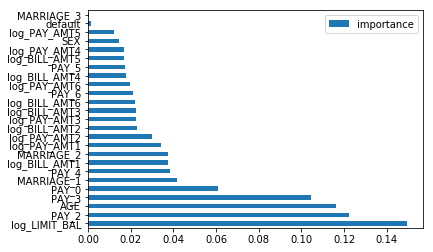

In [42]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = educ.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

ax = feature_importances.plot(kind='barh')
print("Top 3 Feature Importances for Classifying Education")
feature_importances.head(3)

From above we can see that of some of the main features used in the trees for classifying Education as Post Graduate vs All Other we can see that there are several features of importance.

1) log_limit_bal could likely be attributed to the fact that people with post graduate eductations often have a higher salary than ones without. Thus when the bank ran the initial credit check those with higher salaries were afforded a larger credit limit.

2) pay_2 this is the payment status two month out. Interestingly when you look at the plot you can see that the payment status of the last three months all have some level of importance for predicting post graduate education. This is seemingly in line with the expectation that people with graduate degrees have higher salaries. These higher salaries allow them to more reliably pay off their credit cards or not accrue debt on them at all.

3) Age is the third most important feature. Considering that post graduate school would require you to finish a four year school at first it makes sense that age would be an important factor. Card holders aged 18-23 more than likely wouldn't have a post graduate degree.

# Model Deployment


# Deployment

#### The Recommendation to deploy:

Given:
- the relatively low Precision (63% and 59%) for Random Forest in predicting Default and Whether or not someone has a college eduation, and
- the fact that False Positives are not cost-free,

We do not recommend deployment without additional modelling effort.  Such efforts could include:
    
 - Exploring tools such as Logistic Regression, which produce Expected Probabilities.  Deployment could then include acting on cases where the model is more certain of its True Positives.

- Applying a cost function to the model.  If we incorporated the the relative cost of a False Positive to the benefit of a True Positive, the expected impact of deployment could be more clearly guaged.

- Explore simplifying the Explanatory Variables by creating new ones.  One example of variables that could be computed from existing data include the number of times a customer has been delinquent.

The default models could be tested live without any action being taken.  This would essentially be ongoing validation.

#### Measuring the models' success:

When deployed, success of the model could be measured by:
    
- For default, measure whether the prediction turned out to be accurate within a specified window of time.  Validating the impact of the model (i.e. did expected losses decline for those who were given a different collection strategy) should also be undertaken.  Changes in the cost/benefit of deployment could affect the decision to deploy even if model predictions prove accurate.

- For predicting education for marketing purposes, model effectiveness could be measured by changes in response rates for campaigns aimed at those selected by the Mode.


#### Additional Data to be collected:

Examles of data that should be collected:
- Income is likely to be predictive of default, and may be predictive of education.
- Age of the account is likely to be predictive of default.
- Means by which accounts were sourced are could be predictive of either variable.  (e.g. Direct Mail, Branch walk-ins)
- Number of transactions per month.

While we cannot know the extent of the data collection effort, potential sources of data within an organization should be approached to see what data is available.  For example, what data is used to approve a line and set or adjust the credit limit?  Presumably it's more than just age, gender, marital status and education level.  If additional data is available at those decision points, it should be incorporated here.

#### Periodicity of updates:

These models should be updated monthly, as more data become available.  There is an implicit assumption of the age of the data, and that should be maintained.  Given the data, we expect it would be cheap to update.

Other factors to consider with periodicity of updates:
- How sensitive are the models to new data?
- What is the importance of the models?  High impact models should be updated more frequently.


# Exceptional Work

Our Attempt At GPU Computing

We found a project called H2O4GPU by H2O AI https://github.com/h2oai/h2o4gpu#installation which is a collection of GPU solvers with APIs for Python:  

"The Python API builds upon the easy-to-use scikit-learn API and its well-tested CPU-based algorithms. It can be used as a drop-in replacement for scikit-learn (i.e. import h2o4gpu as sklearn) with support for GPUs on selected (and ever-growing) algorithms. H2O4GPU inherits all the existing scikit-learn algorithms and falls back to CPU algorithms when the GPU algorithm does not support an important existing scikit-learn class option."  

We have access to an Nvidia Geforce RTX 2080.  
We installed:  
- Ubuntu 18.04LTS  
- NVidia Drivers for Ubuntu  
- NVidia Cuda Kit
- H2O4GPU  
- Many other small things  

We were able to run the following test which indicates that the enivironment is doing something:

In [1]:
import h2o4gpu
import numpy as np

X = np.array([[1.,1.], [1.,4.], [1.,0.]])
model = h2o4gpu.KMeans(n_clusters=2,random_state=1234).fit(X)
model.cluster_centers_

array([[1. , 0.5],
       [1. , 4. ]])

However our attempts to make our models (SVM's in particular) function resulted in crashing kernels.  

The libraries are designed for  
-Ubuntu 16.04  
-Python 3.6  
-Cuda 9.2  

Our RTX2080 GPU is the very latest technology (as of the time of this writing) from NVIdia. It's driver version is only compatible with Cuda 10.0 which conflicts with H2O4GPU's 9.2 requirement. Also in hindsight we should have been running Ubuntu 16.04 rather than 18.04.

There is a PCA example provided by H2O which apparently is functional in this simple case (see below) however again when we adapted our PCA our Kernel crashed.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

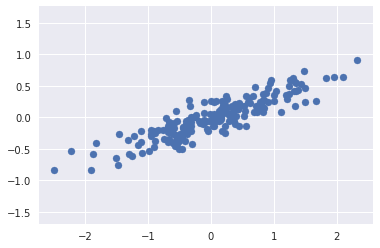

In [3]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [4]:
from h2o4gpu.solvers.pca import PCAH2O
pca = PCAH2O(n_components=2)
pca.fit(X)

In [5]:
print(pca.components_)

[[-0.94446027 -0.32862556]
 [-0.32862556  0.94446027]]


In [6]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


In [8]:
pca = PCAH2O(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


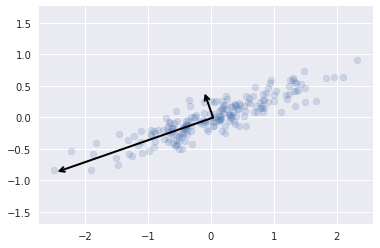

In [7]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

In [8]:
pca = PCAH2O(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


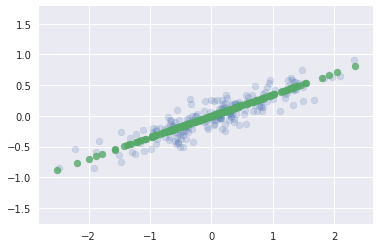

In [9]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

### Conclusion  

H2O4GPU can function for some use cases with the right hardware and software environment. However it still needs development before we can rely on it unless we enhance our C++ programming skills.